In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Load images, labels, masks

In [2]:
NPY_PATH = r"dataset\numpy"

labels = np.load(os.path.join(NPY_PATH,'labels.npy'))
t1w_images = (np.load(os.path.join(NPY_PATH,'T1W_images.npy')) / 255.0).astype(np.float32)
t2f_images = (np.load(os.path.join(NPY_PATH,'T2F_images.npy')) / 255.0).astype(np.float32)
t2w_images = (np.load(os.path.join(NPY_PATH,'T2W_images.npy')) / 255.0).astype(np.float32)
masks = (np.load(os.path.join(NPY_PATH,'Mask_images.npy')) / 255.0).astype(np.float32)

print(masks.shape)

(2356, 260, 320)


In [3]:
# 모델의 입력 형태에 맞추기 위해 차원을 확장합니다.
# example. (,260,320) -> (,260,320,1)
t1w_images = np.expand_dims(t1w_images,axis=-1)
t2f_images = np.expand_dims(t2f_images,axis=-1)
t2w_images = np.expand_dims(t2w_images,axis=-1)
masks = np.expand_dims(masks,axis=-1)

# Resizing

In [4]:
from util import downsample

img_size_ori = (260,320)
img_size_target = (256,256)

t1w_images = np.array([ downsample(image,img_size_ori,img_size_target) for image in t1w_images ])
t2f_images = np.array([ downsample(image,img_size_ori,img_size_target) for image in t2f_images ])
t2w_images = np.array([ downsample(image,img_size_ori,img_size_target) for image in t2w_images ])
masks = (np.array([ downsample(mask,img_size_ori,img_size_target) for mask in masks ])>0)*1.0

# Train & Test Split

In [5]:
from sklearn.model_selection import train_test_split
import gc

image_datasets = np.concatenate((t1w_images,t2f_images,t2w_images),axis=0)
mask_datasets = np.concatenate((masks,masks,masks),axis =0)
labels_datasets = np.concatenate((labels,labels,labels),axis =0)

X,X_v,Y,Y_v = train_test_split( image_datasets,mask_datasets,test_size=0.2,stratify=labels_datasets,random_state=444, shuffle=True)

del image_datasets
del mask_datasets
del labels_datasets

gc.collect()

0

In [6]:
from model import baseModel, unet_v1, unet_v2, unet_v3

unet = baseModel(input_shape=(256,256,1))
unet.summary()

Model: "unet_base"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
contraction_1_1 (Conv2D)        (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
contraction_1_2 (Conv2D)        (None, 256, 256, 64) 36928       contraction_1_1[0][0]            
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           contraction_1_2[0][0]            
__________________________________________________________________________________________

In [7]:
from keras.models import load_model
from util import bce_dice_loss, getIOUCurve

model_path = r"model_base_256_best_checkpoint.h5"
unet = load_model(model_path, custom_objects={'bce_dice_loss': bce_dice_loss,'iou_metric':tf.keras.metrics.MeanIoU(num_classes=2,name="mean_iou")})

In [ ]:
predicted_data = unet.predict(X_v)

Text(0.5, 1.0, 'Threshold vs IoU \n (0.09090909090909091, 0.6806807518005371)')

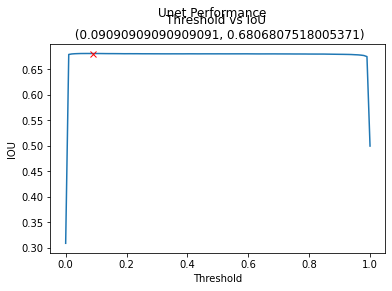

In [8]:
f, (ax1) = plt.subplots(1,1, figsize=(6, 4))
t = f.suptitle('Unet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

th, ious, iou_best, th_best = getIOUCurve(Y_v,predicted_data)
ax1.plot(th, ious,label="For Validation")
ax1.plot(th_best, iou_best, "xr", label="Best threshold")
ax1.set_ylabel('IOU');ax1.set_xlabel('Threshold')
ax1.set_title("Threshold vs IoU \n ({}, {})".format(th_best, iou_best))

In [9]:
predicted_mask = (predicted_data>(0.5))*1

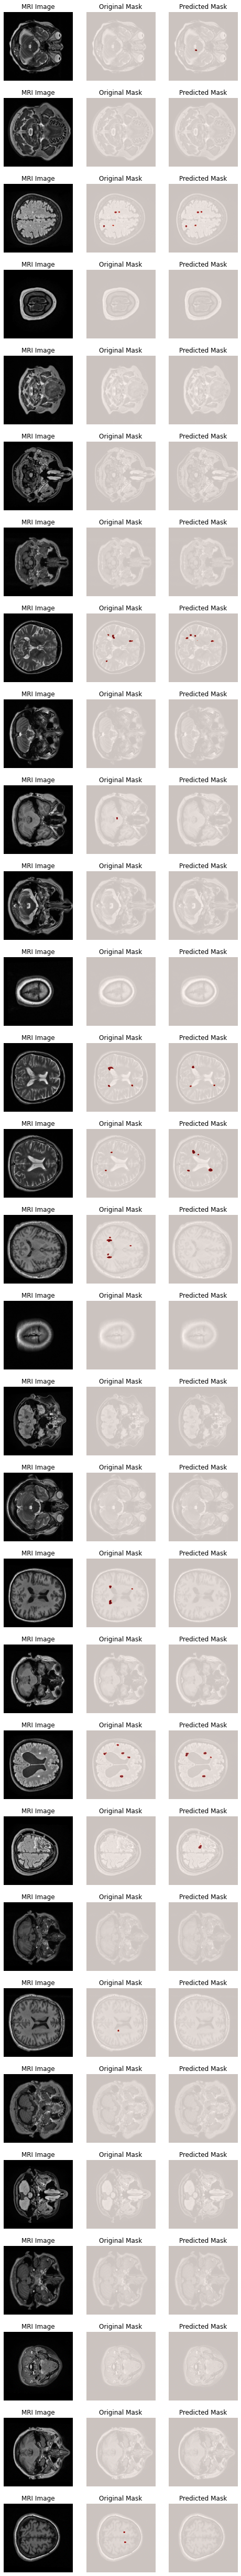

In [10]:
i=1;total=30
temp = np.ones_like( Y_v[0] )

plt.figure(figsize=(8,90))
# for idx in np.random.randint(0,high=X_v.shape[0],size=total):
for idx in range(120,120+total):
    plt.subplot(total,3,i);i+=1
    plt.imshow(X_v[idx], cmap='gray' )
    plt.title("MRI Image");plt.axis('off')
    
    plt.subplot(total,3,i);i+=1
    plt.imshow( X_v[idx], cmap='gray' )
    plt.imshow( Y_v[idx], alpha=0.8, cmap='Reds' )
    plt.title("Original Mask");plt.axis('off')
    
    plt.subplot(total,3,i);i+=1
    plt.imshow( X_v[idx], cmap='gray' )
    plt.imshow( predicted_mask[idx],  alpha=0.8, cmap='Reds' )
    plt.title("Predicted Mask");plt.axis('off')